<a href="https://colab.research.google.com/github/lunayee/Titanic-Machine-Learning-from-Disaster-/blob/main/Titanic_Machine_Learning_from_Disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 載入套件

In [1]:
import pandas as pd
import numpy as np
#繪圖相關套件
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
plt.style.use('ggplot')
#標籤編碼
from sklearn.preprocessing import LabelEncoder, OneHotEncoder 
#決策樹
from sklearn.tree import DecisionTreeClassifier
#隨機森林(Random Forest)
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display

import warnings
warnings.filterwarnings( 'ignore' )

# 上傳資料
透過Kaggle資料競賽，下載鐵達尼號資料集(Link: https://www.kaggle.com/c/titanic/data)

In [2]:
from google.colab import files
uploaded = files.upload

# 匯入資料
透過pandas匯入訓練及測試資料，利用shape得知資料維度

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
submit = pd.read_csv('gender_submission.csv')
print(f'train {df_train.shape}')
display(df_train.head())
print(f'\ntest{df_test.shape}')
display(df_test.head())


train (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



test(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# 欄位型態
自定義Col_Types，觀察訓練及測試共同特徵欄位型態

In [4]:
#定義判別欄位型態的函數
def Col_Types(Data):
  Column_Types = Data.dtypes.to_frame().reset_index() #判別每個欄位的型態
  Column_Types.columns =['ColumnName','Type']
  Column_Types.sort_values(by='Type',inplace=True)
  return Column_Types 

In [5]:
display(Col_Types(df_train))

,ColumnName,Type
0,PassengerId,int64
1,Survived,int64
2,Pclass,int64
6,SibSp,int64
7,Parch,int64
5,Age,float64
9,Fare,float64
3,Name,object
4,Sex,object
8,Ticket,object


# 遺漏值
分析資料前要先確認是否有漏值，如果有需要用特徵工程來補植

In [6]:
#找漏值
def Missing_Count(Data):
  missing = Data.isnull().sum() #漏值的數量
  missing = missing[missing>0]
  missing.sort_values(inplace=True)

  Missing_Count = pd.DataFrame({'ColumnName':missing.index,'MissingCount':missing.values})
  Missing_Count['Percentage(%)']=Missing_Count['MissingCount'].apply(lambda x:round(x/Data.shape[0]*100,2))
  return Missing_Count

In [7]:
print('train:')
display(Missing_Count(df_train))
print('test:')
display(Missing_Count(df_test))

train:


,ColumnName,MissingCount,Percentage(%)
0,Embarked,2,0.22
1,Age,177,19.87
2,Cabin,687,77.10


test:


,ColumnName,MissingCount,Percentage(%)
0,Fare,1,0.24
1,Age,86,20.57
2,Cabin,327,78.23


# 統計量
利用describe()，可以計算每個數值欄位的統計量，可當作判斷離群值的依據，並決定是否要對資料進行正規化or標準化

In [8]:
print('train:')
display(df_train.describe())

print('teat:')
display(df_test.describe())

train:


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


teat:


,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


# 資料分析
使用append()隊訓練及與測試集的資料合併，方便後續修補或調整資料

In [9]:
df_data = df_train.append(df_test)
display(df_data.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 生還者比率
分析生還者與罹難者比率是否有明顯極大的落差，看有沒有資訊不平衡的問題，方法為:使用value_count()表示各類別中相異的數量

In [10]:
Survived_Count = df_data['Survived'].value_counts().reset_index()
Survived_Count.columns = ['Survived','Count']
Survived_Count

,Survived,Count
0,0.0,549
1,1.0,342


<function matplotlib.pyplot.show>

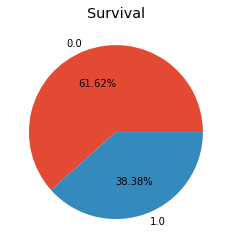

In [11]:
plt.figure()
df_data['Survived'].value_counts().plot(kind='pie',autopct='%1.2f%%')
plt.title('Survival')
plt.ylabel('')
plt.show

## 相關係數
利用corr()，計算相關係數，看有沒有明顯的線性關係

In [12]:
Corr_Matrix = df_train.corr()
Corr = Corr_Matrix.loc['Survived'].sort_values()[:-1]
Corr = pd.DataFrame({'Survived':Corr})
Corr

,Survived
Pclass,-0.338481
Age,-0.077221
SibSp,-0.035322
PassengerId,-0.005007
Parch,0.081629
Fare,0.257307


## 生存率
觀察其他欄位與生存率的關係

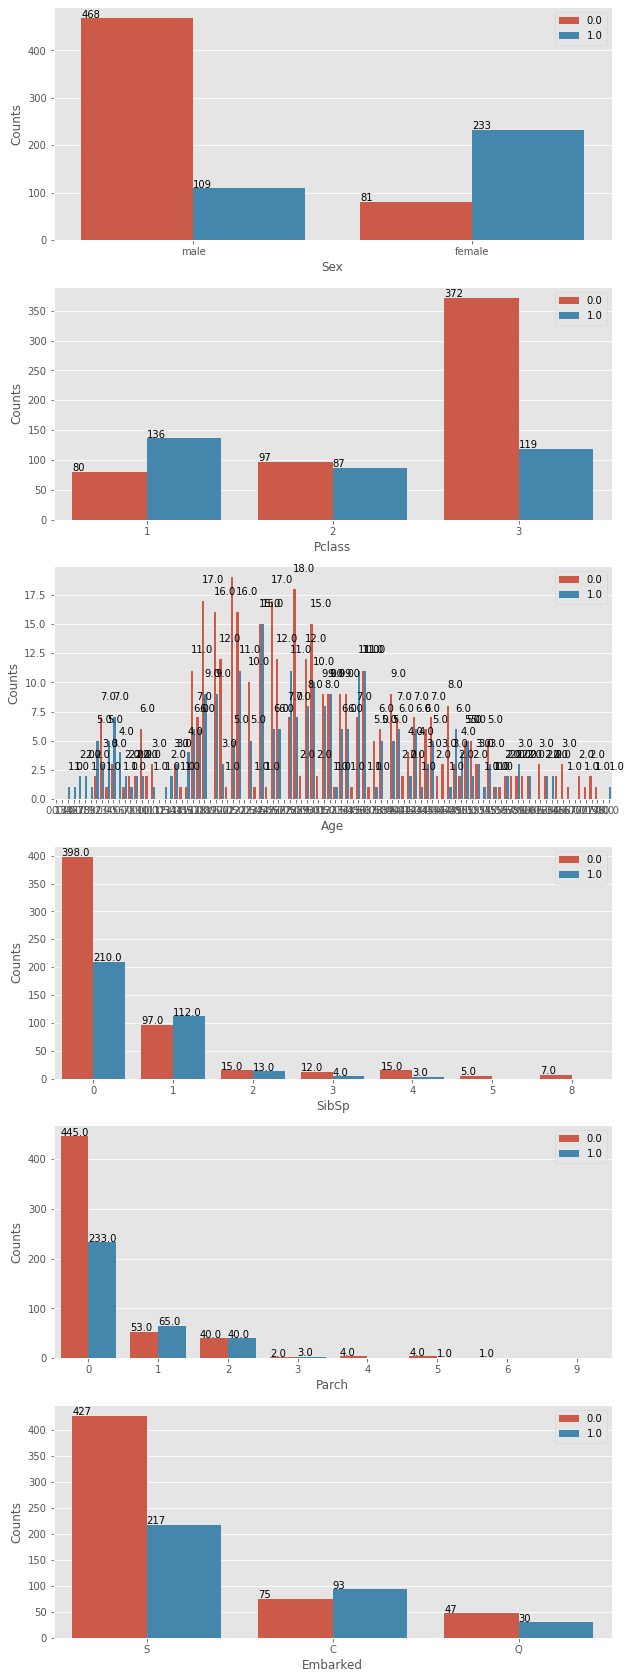

In [13]:
selected_cols=['Sex','Pclass','Age','SibSp','Parch','Embarked']
plt.figure(figsize=(10,len(selected_cols)*5))
gs = gridspec.GridSpec(len(selected_cols),1)
for i, col in enumerate( df_data[selected_cols] ) :        
    ax = plt.subplot( gs[i] )
    sns.countplot( df_data[col], hue=df_data.Survived )
    ax.set_ylabel( 'Counts' )
    ax.legend( loc=1 )   # 圖示位置 upper right:1 ; upper left:2
    for p in ax.patches:
        ax.annotate( '{:,}'.format(p.get_height()), (p.get_x(), p.get_height()+1.5) )#顯示數值
plt.show()

# 特徵工程
分析資料後，處理一些無法直接餵入模型的欄位

## (1)字串欄位

### 姓名
發現擷取出稱謂可能可以提升預測準確度，處理字串資料常用函數有split(),repalce()

In [14]:
# Method 1: split()
df_data['Title'] = df_data.Name.str.split(', ', expand=True)[1]
df_data['Title'] = df_data.Title.str.split('.', expand=True)[0]
df_data['Title'].unique()#留下不重複的值

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [15]:
# Method 2: 正規表示法(Regular Expression)
import re

regex = re.compile( ' ([A-Za-z]+)\.' )  
df_data['Title'] = df_data.Name.map( lambda x:regex.search(x)[0] )
# Dropping the first and the last words
df_data['Title'] = df_data.Title.map( lambda x:x[1:][:-1] )  
df_data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer', 'Dona'], dtype=object)

將同樣性別或關係的稱謂合併，避免產生某些稱謂僅有少數乘客，例如：Rev(Reverend)為牧師的尊稱、Countess為伯爵夫人等，影響模型的預測準確度。這裏我們將利用 replace( ) 函數，將上述擷取出的稱謂總歸為五類：Mr、Mrs、Miss、Master、Rare。

In [16]:
df_data['Title'] = df_data.Title.replace( ['Don','Rev','Dr','Major','Lady','Sir','Col','Capt','Countess','Jonkheer','Dona'], 'Rare' )
df_data['Title'] = df_data.Title.replace( ['Ms','Mlle'], 'Miss' )
df_data['Title'] = df_data.Title.replace( 'Mme', 'Mrs' )
df_data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Rare'], dtype=object)

In [17]:
# 刪除原始資料中的 Name 欄位 
df_data.drop( 'Name', axis=1, inplace=True )#inplace=True表示修改原本值，默認為flase

### 船票號碼
假設船票中，前面英文字母表示位於同個區域中，擷取船票字串部分文字訊息，作為位置分區

In [18]:
df_data['Ticket_info']=df_data.Ticket.apply(lambda x:x.replace('.','').replace('/','').split(' ')[0].strip() if not x.isdigit() else 'X')#strip()刪除前後空格
df_data['Ticket_info'].unique()

array(['A5', 'PC', 'STONO2', 'X', 'PP', 'CA', 'SCParis', 'SCA4', 'A4',
       'SP', 'SOC', 'WC', 'SOTONOQ', 'WEP', 'STONO', 'C', 'SCPARIS',
       'SOP', 'Fa', 'LINE', 'FCC', 'SWPP', 'SCOW', 'PPP', 'SC', 'SCAH',
       'AS', 'SOPP', 'FC', 'SOTONO2', 'CASOTON', 'SCA3', 'STONOQ', 'AQ4',
       'A', 'LP', 'AQ3'], dtype=object)

In [19]:
#刪除本來的Ticket資料
df_data.drop('Ticket',axis=1,inplace=True)

## (2)填補缺漏值
運用平均、中位數、眾數、線性回歸、決策數等補植，並利用fillna函數填補

In [20]:
Missing_Count(df_data.drop('Survived',axis=1))


,ColumnName,MissingCount,Percentage(%)
0,Fare,1,0.08
1,Embarked,2,0.15
2,Age,263,20.09
3,Cabin,1014,77.46


### 票價:用中位數填補

In [21]:
df_data['Fare'].fillna(df_data.Fare.median(),inplace=True)

### 登船港口:用眾數填補

In [22]:
display(df_data['Embarked'].value_counts())
df_data['Embarked'].fillna('S',inplace=True)

S    914
C    270
Q    123
Name: Embarked, dtype: int64

### 年齡
因為它缺漏太多，可能會影響預測結果，此時用age搭配Sex,Pclass欄位觀察

In [23]:
df_data['isAge']=df_data['Age'].isnull().apply(lambda x:0 if x==True else 1)
display(pd.crosstab(df_data.isAge,df_data.Sex,margins=True))
display(pd.crosstab(df_data.isAge,df_data.Pclass,margins=True))

Sex,female,male,All
isAge,,,
0,78,185,263
1,388,658,1046
All,466,843,1309


Pclass,1,2,3,All
isAge,,,,
0,39,16,208,263
1,284,261,501,1046
All,323,277,709,1309


Age 欄位的缺漏值明顯分佈在 Pclass 3 中，約佔 29.34%(=208/709)，進一步觀察在 Pclass 1 及 Pclass 2 的乘客中，Age 欄位對於存活率是否有明顯的影響？

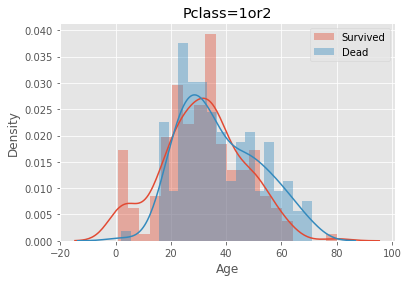

In [24]:
index_S=(df_data.isAge==1)&(df_data.Pclass!=3)&(df_data.Survived==1)
index_D=(df_data.isAge==1)&(df_data.Pclass!=3)&(df_data.Survived==0)
plt.figure()
sns.distplot(df_data.loc[index_S,'Age'],label='Survived',bins=20)
sns.distplot(df_data.loc[index_D,'Age'],label='Dead',bins=20)
plt.title('Pclass=1or2')
plt.legend()

從上圖可觀察到，在 Pclass 1 及 Pclass 2 的乘客中，年齡約小於 17 歲的乘客中有明顯較高的生存率，若年齡超過 17 歲則生存率並無明顯的差別，所以我們可大膽假設 Age 欄位與生存率具有關聯性，另外，因為年齡與稱謂(Title)也有相當程度的關聯，因此，我們將先計算每個稱謂的年齡平均值，再用此平均值來填補每個 Title 中所對應 Age 欄位的缺漏值

In [25]:
# 計算每個 Title 的年齡平均值及中位數
Age_Mean=df_data[['Title','Age']].groupby(by=['Title']).mean()
Age_Median=df_data[['Title','Age']].groupby(by=['Title']).median()

Age_Mean.columns =['Age Mean']
Age_Median.columns =['Age Median']
Age_Mean.reset_index( inplace=True )#整理表格
Age_Median.reset_index( inplace=True )

display(Age_Mean)
display(Age_Median)

,Title,Age Mean
0,Master,5.482642
1,Miss,21.824366
2,Mr,32.252151
3,Mrs,36.918129
4,Rare,45.178571


,Title,Age Median
0,Master,4.0
1,Miss,22.0
2,Mr,29.0
3,Mrs,35.0
4,Rare,47.5


In [26]:
# 利用每個 Title 的年齡平均數，填補每個 Title 所對應 Age 的缺漏值
df_data.loc[(df_data.Age.isnull())&(df_data.Title=='Master'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Master','Age Mean'][0]
df_data.loc[(df_data.Age.isnull())&(df_data.Title=='Miss'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Miss','Age Mean'][1]
df_data.loc[(df_data.Age.isnull())&(df_data.Title=='Mr'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Mr','Age Mean'][2]
df_data.loc[(df_data.Age.isnull())&(df_data.Title=='Mrs'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Mrs','Age Mean'][3]
df_data.loc[(df_data.Age.isnull())&(df_data.Title=='Rare'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Rare','Age Mean'][4]

# 刪除 isAge 欄位 
df_data.drop( 'isAge', axis=1, inplace=True )

填滿 Age 欄位的缺漏值後，我們將年齡特徵再區分成未滿17歲及17歲以上，未滿17歲的乘客標為1，17歲以上的乘客標為0

In [27]:
# 乘客年齡是否未滿17歲(是：1；否：0)
df_data['is_Age_17'] = (df_data.Age<17)*1
df_data

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Ticket_info,is_Age_17
0,1,0.0,3,male,22.000000,1,0,7.2500,NaN,S,Mr,A5,0
1,2,1.0,1,female,38.000000,1,0,71.2833,C85,C,Mrs,PC,0
2,3,1.0,3,female,26.000000,0,0,7.9250,NaN,S,Miss,STONO2,0
3,4,1.0,1,female,35.000000,1,0,53.1000,C123,S,Mrs,X,0
4,5,0.0,3,male,35.000000,0,0,8.0500,NaN,S,Mr,X,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,male,32.252151,0,0,8.0500,NaN,S,Mr,A5,0
414,1306,NaN,1,female,39.000000,0,0,108.9000,C105,C,Rare,PC,0
415,1307,NaN,3,male,38.500000,0,0,7.2500,NaN,S,Mr,SOTONOQ,0
416,1308,NaN,3,male,32.252151,0,0,8.0500,NaN,S,Mr,X,0


### 船艙號碼
缺漏值過多，僅取出頭一個英文字母作為分類標籤其他缺漏值以NoCabin表示

In [28]:
#觀察船艙的種類
df_data['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [29]:
#取出第一個字母
df_data['Cabin']=df_data['Cabin'].apply(lambda x:str(x)[0] if not pd.isnull(x) else 'NoCabin')
df_data['Cabin'].unique()

array(['NoCabin', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

最後檢查有沒有沒補到的值

In [30]:
Missing_Count(df_data)

,ColumnName,MissingCount,Percentage(%)
0,Survived,418,31.93


## (3)離群值
利用直方圖或盒鬚圖判斷

### 票價

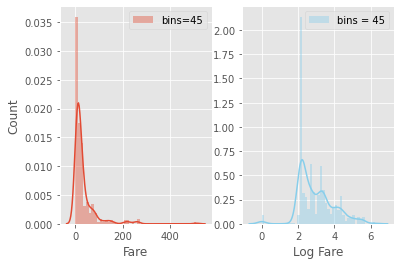

In [31]:
# 對 Fare 欄位取對數
df_data['LogFare'] = np.log1p( df_data.Fare )
# 直方圖(Histogram)
fig, axs = plt.subplots(1,2)

plt.subplot(1,2,1)
sns.distplot(df_data.Fare,bins=45,label='bins=45')
plt.xlabel('Fare')
plt.ylabel('Count')
plt.legend()

plt.subplot( 1,2,2 )
sns.distplot( df_data.LogFare, kde=True, bins=45, color='skyblue', label='bins = 45' )
plt.xlabel( 'Log Fare' ) 
plt.ylabel( '' ) 
plt.legend( )



Text(0.5, 0, 'Log Fare')

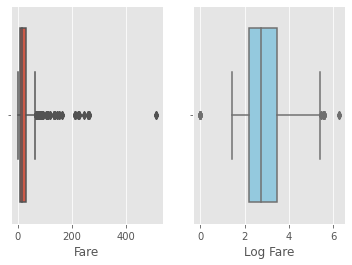

In [32]:
#盒鬚圖
fig,axs=plt.subplots(1,2)

plt.subplot(1,2,1)
sns.boxplot(df_data.Fare)
plt.xlabel('Fare')

plt.subplot( 1,2,2 )
sns.boxplot( df_data.LogFare, orient='h', color='skyblue' )
plt.xlabel( 'Log Fare' ) 

從上面直方圖及盒鬚圖可知，初步判斷 Fare 欄位可能存有離群值，計算 Fare 欄位的四分位數(Quartile)，且以四分位數對 Fare 欄位進行分組，觀察生存率是否會因票價組別的高低有所差異，

In [33]:
#計算各個百分位數
Q1 =np.percentile( df_data.Fare,q=25)
Q2 =np.percentile( df_data.Fare,q=50)
Q3 =np.percentile( df_data.Fare,q=75)
IQR=Q3-Q1

# 依照四分位數，對 Fare 欄位進行分組
Fare_bin = [ 0, Q1, Q2, Q3, Q3+1.5*IQR, df_data.Fare.max() ]
df_data[ 'Fare_Group' ] = pd.cut( df_data.Fare.values, Fare_bin )
Group_Count=df_data[ 'Fare_Group' ].value_counts().reset_index()
Group_Count.columns=['Fare_Group', 'Counts']
Group_Count.sort_values(by='Fare_Group')

,Fare_Group,Counts
2,"(0.0, 7.896]",320
1,"(7.896, 14.454]",321
0,"(14.454, 31.275]",328
4,"(31.275, 66.344]",152
3,"(66.344, 512.329]",171


再次藉由長條圖及盒鬚圖，觀察不同的票價組別，彼此間生存率的差異性

Text(0, 0.5, 'Count')

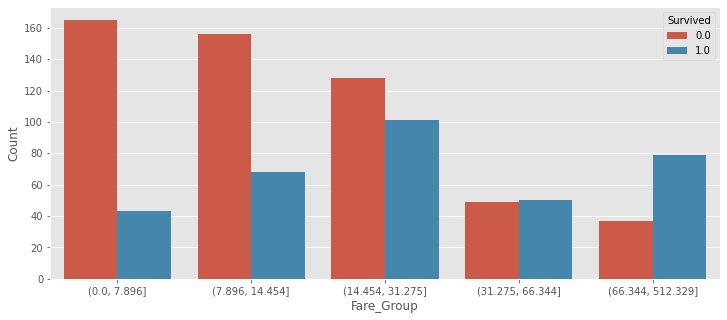

In [34]:
plt.subplots( figsize=(12,5) )
sns.countplot(df_data.Fare_Group,hue=df_data.Survived)
plt.ylabel('Count')


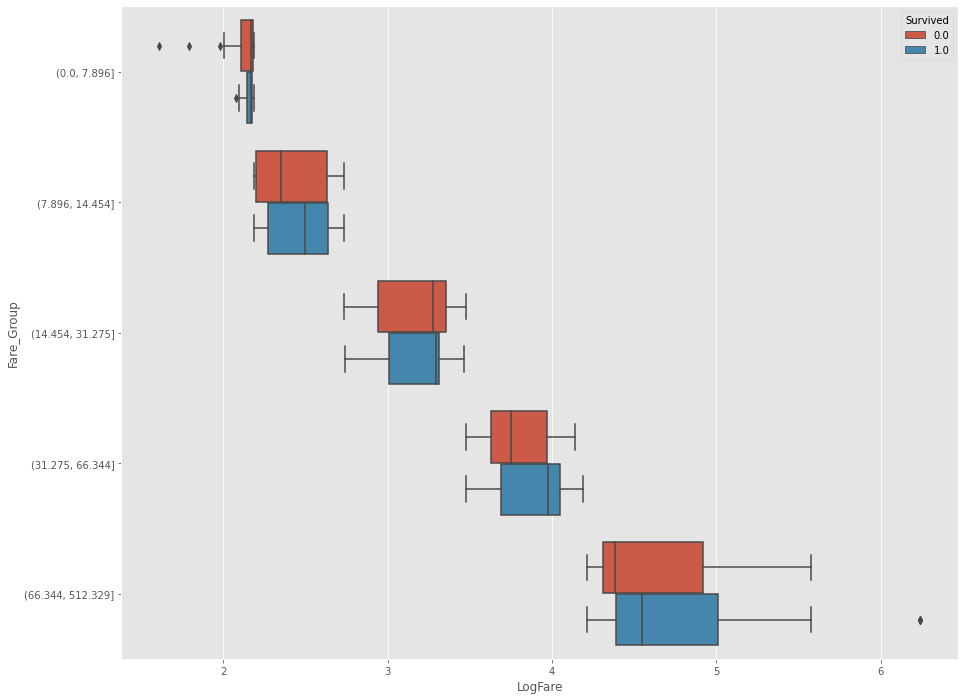

In [35]:
plt.subplots( figsize=(15,12) )
sns.boxplot( x='LogFare', y='Fare_Group', data=df_data, hue='Survived' )


從上圖可明顯觀察出，票價組別越高生存率相對越大，且每一票價組別中，生還者的票價中位數皆高於罹難者的票價中位數；所以，我們可大膽推測 Fare 與生存率有相關性，Fare 越高生存機率越大，且對 Fare 欄位僅做對數轉換並不做離群值的處理。

## (4)讀熟編碼、標籤編碼
對於定性且無序的特徵欄位可以利用get_dummies()將其轉換成定量資料，這裏我們對 Embarked 欄位做獨熱編碼；另外，因為女性的生存率明顯高於男性，故我們對 Sex 欄位做標籤編碼。


*   熟讀編碼(One hot encoding) : 為每個類別新增一個欄位，用 0/1 表示是否
*   標籤編碼(Label encoding) : 把每個類別 mapping 到某個整數，不會增加新欄位




### 登船港口

In [36]:
OneHot_Embarked = pd.get_dummies( df_data.Embarked,prefix='Embarked' )
df_data=pd.concat([df_data,OneHot_Embarked],axis=1)
df_data.drop( 'Embarked', axis=1, inplace=True )


### 性別

In [37]:
# Label Encoding
Sex_mapping = { 'male':0, 'female':1 }
df_data[ 'Sex' ] = df_data.Sex.map( Sex_mapping )


# 訓練集與測試集
先確認是否每個欄位都皆為數值狀態，並且將資料分割回訓練及測試

In [38]:
df_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Title,Ticket_info,is_Age_17,LogFare,Fare_Group,Embarked_C,Embarked_Q,Embarked_S
0,1,0.0,3,0,22.0,1,0,7.2500,NoCabin,Mr,A5,0,2.110213,"(0.0, 7.896]",0,0,1
1,2,1.0,1,1,38.0,1,0,71.2833,C,Mrs,PC,0,4.280593,"(66.344, 512.329]",1,0,0
2,3,1.0,3,1,26.0,0,0,7.9250,NoCabin,Miss,STONO2,0,2.188856,"(7.896, 14.454]",0,0,1
3,4,1.0,1,1,35.0,1,0,53.1000,C,Mrs,X,0,3.990834,"(31.275, 66.344]",0,0,1
4,5,0.0,3,0,35.0,0,0,8.0500,NoCabin,Mr,X,0,2.202765,"(7.896, 14.454]",0,0,1


## 類別型態轉為整數
檢視後發現，因為我們之前有處理過字串欄位，所以資料中還存有 4 欄類別型態的欄位：Cabin、Embarked、Title、Ticket_info，因此，我們也需要將它們轉換成數值型態欄位：

In [39]:
for col in ['Title','Ticket_info','Cabin']:
  df_data[col]= df_data[col].astype('category').cat.codes

df_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Title,Ticket_info,is_Age_17,LogFare,Fare_Group,Embarked_C,Embarked_Q,Embarked_S
0,1,0.0,3,0,22.0,1,0,7.2500,7,2,2,0,2.110213,"(0.0, 7.896]",0,0,1
1,2,1.0,1,1,38.0,1,0,71.2833,2,3,14,0,4.280593,"(66.344, 512.329]",1,0,0
2,3,1.0,3,1,26.0,0,0,7.9250,7,1,31,0,2.188856,"(7.896, 14.454]",0,0,1
3,4,1.0,1,1,35.0,1,0,53.1000,2,3,36,0,3.990834,"(31.275, 66.344]",0,0,1
4,5,0.0,3,0,35.0,0,0,8.0500,7,2,36,0,2.202765,"(7.896, 14.454]",0,0,1


## 訓練集&測試集
最後，我們將整體資料分割回訓練集與測試集兩部份，訓練集用來餵入模型進行訓練

In [40]:
#刪除毫無關聯的欄位
df_data.drop(['PassengerId','Fare','Fare_Group'],inplace=True,axis=1)

In [45]:
# 產生訓練集和測試集
Train = df_data[pd.notnull(df_data.Survived)]
Test = df_data[pd.isnull(df_data.Survived)]
Test.drop(['Survived'],axis=1,inplace=True)

#將測試的Survived單獨拆出
Y_Train=Train.Survived
X_Train=Train.drop(['Survived'],axis=1)

print( f'Shape of X_Train = {X_Train.shape}' )
print( f'Shape of Y_Train = {Y_Train.shape}' )
print( f'Shape of Test = {Test.shape}' )

Shape of X_Train = (891, 13)
Shape of Y_Train = (891,)
Shape of Test = (418, 13)


# 特徵重要性
使用最基本的樹狀模型 - 決策樹(Decision Tree)，來評估特徵欄位對於標籤欄位(Survived)的重要性

In [53]:
#建立決策樹
DTC = RandomForestClassifier()
DTC.fit(X_Train,Y_Train)
#排序特徵重要性
col_names=X_Train.columns
importances=DTC.feature_importances_
Feature_Rank=pd.DataFrame({'Feature_Name':col_names,'Importance':importances})
Feature_Rank.sort_values(by='Importance',inplace=True,ascending=False)
Feature_Rank

,Feature_Name,Importance
2,Age,0.210215
9,LogFare,0.202834
1,Sex,0.171163
6,Title,0.107771
0,Pclass,0.068162
5,Cabin,0.066783
3,SibSp,0.046110
7,Ticket_info,0.043400
4,Parch,0.033389
10,Embarked_C,0.016254


# 建立模型
在完成評估特徵重要性後，我們選擇使用隨機森林(Random Forest)來預測資料

In [54]:
# 隨機森林參數：
# n_estimators: 樹的數量(default=10)。
# min_samples_leaf: 最終葉節點最少樣本數(default=1)；
#                   當樣本不大時，可不設定使用預設，若樣本數量非常大時，則推薦增加此參數值。
# min_samples_split:節點再劃分時所需的最小樣本數(default=2)；
#                   當樣本不大時，可不設定使用預設，若樣本數量非常大時，則推薦增加此參數值。
# oob_score: 是否採用袋外樣本(out-of-bag samples)(未使用的樣本)來評估模型的準確度(default=False)。

RFC = RandomForestClassifier( n_estimators = 1000,min_samples_split = 20,min_samples_leaf = 1,oob_score = True,random_state = 1,n_jobs = -1 ) 

# 訓練模型
餵入訓練集資料(X_Train,Y_Train)訓練隨機森林(Random Forest)模型。一般而言，為了衡量模型的預測能力，在訓練模型之前，我們還會從訓練集中抽取出一小部份作為驗證集(Validation)，用來評估模型的準確度，而剩下沒被抽取到的資料則用來訓練模型，另外，為避免只參考某一特定的抽樣驗證結果，導致模型產生偏差，我們會藉由交叉驗證(Cross Validation)，來評估模型的準確度是否能達到我們要求的水準。
因為隨機森林可藉由前述所提的袋外樣本評估準確度，因此這裏我們便不需進行交叉驗證；然而，我們還想知道特徵欄位的多寡對於模型準確度的影響，所以，先把所有的欄位餵入模型進行訓練：


In [55]:
# 訓練模型
RFC.fit( X_Train, Y_Train )
print( 'oob_score = {:.6f}'.format(RFC.oob_score_) )

oob_score = 0.827160


將所有的特徵欄位餵入模型進行訓練，訓練完成的模型準確率約 82.7%；接下來，我們試著參考上述特徵重要性的結果，只選擇部份特徵欄位來訓練模型，觀察這樣的模型準確度是否能有所提升？

In [58]:
RFC_2 = RandomForestClassifier( n_estimators = 1000,min_samples_split = 20,min_samples_leaf = 1,oob_score = True,random_state = 1,n_jobs = -1 ) 

# 篩選部份特徵欄位餵入模型進行訓練
SelectedFeatures = ['Age','Sex','LogFare','Title','Pclass','Cabin']
RFC_2.fit( X_Train[SelectedFeatures], Y_Train )

print( f'Selected Features :\n   {SelectedFeatures}' )
print( 'oob_score = {:.6f}'.format(RFC_2.oob_score_) )

Selected Features :
   ['Age', 'Sex', 'LogFare', 'Title', 'Pclass', 'Cabin']
oob_score = 0.841751


經觀察，只篩選部份特徵欄位所訓練出的模型準確率約 84.1%，略高於所有特徵欄位所訓練出的模型，從這我們可得到一個寶貴的經驗，就是適當的挑選出關鍵性的特徵欄位進行訓練，對於模型的準確度將會有所提升

# 測試集預測

In [61]:
# 預測測試集資料
Test_pred = RFC_2.predict( Test[SelectedFeatures] )

# 檢視預測罹難或生還的機率
#print( RFC_2.predict_proba(Test[SelectedFeatures]) )

# 提交檔案
submit['Survived'] = Test_pred.astype(int)
submit.to_csv( 'Titanic_RandomForest.csv', index=False )
print( f'預測結果：' )
submit 

預測結果：


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
